# Тестовое задание 

   Ваша задача написать пайплайн для тренировки модели глубоко обучения (любую – **embeddings + LSTM, Bert** …) с использованием следующих инструментов: pytorch, sklearn, matplotlib – для решения задачи **NER** (извлечения сущностей).

   В качестве данных используется датасет **Conll2003** с четырьмя классами **Per, Org, Loc, Misc** в формате **Conll**.

   В тетрадке ниже заданы основные классы и функции для построения требуемого пайплайн, какие-то уже имплементированы, какие-то – нет. Их требуется доработать. Тем не менее если данный набор абстракций вам не подходит Вы можете написать свой пайплайн «с нуля», однако обоснованность у этих действий должна быть.

**Что оценивается в первую очередь:**
- Выбранная архитектура для решения задачи
- Выбранные предобученные веса 
- Полученные метрики

**Затем:**
- Глубина разведочного анализа
- Какая схема теггирования используется (**BIO, IO** или другие)
- Каким образом производится расчет метрик (потокенный отчет, отчет по точному совпадению спанов сущностей)

**С меньшим приоритетом:** 
- Скорость предобработки и постобработки данных 
- Стиль кода

In [1]:
!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa
!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train

--2021-05-22 11:25:15--  https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 827012 (808K) [text/plain]
Saving to: ‘eng.testa’

eng.testa           100%[===================>] 807.63K  --.-KB/s    in 0.03s   

2021-05-22 11:25:16 (24.6 MB/s) - ‘eng.testa’ saved [827012/827012]

--2021-05-22 11:25:16--  https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3281528 (3.1M) [text/plain]
S

In [2]:
!head eng.train 

-DOCSTART- -X- O O

EU NNP I-NP I-ORG
rejects VBZ I-VP O
German JJ I-NP I-MISC
call NN I-NP O
to TO I-VP O
boycott VB I-VP O
British JJ I-NP I-MISC
lamb NN I-NP O


In [3]:
!pip install transformers

     |████████████████████████████████| 2.3MB 7.3MB/s 
     |████████████████████████████████| 3.3MB 37.9MB/s 
     |████████████████████████████████| 901kB 49.5MB/s 


In [4]:
!pip -q install seqeval

     |████████████████████████████████| 51kB 4.8MB/s 


In [5]:
from torch.utils.data import Dataset, DataLoader, RandomSampler
from typing import List
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn
import torch
from sklearn.metrics import classification_report
import numpy as np
import itertools

from transformers import BertTokenizer

from seqeval.metrics import f1_score
from seqeval.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [6]:
def read_data(file):
  lines = open(file, "r").readlines()
  data = {"sentences": [], "labels_per_sent": []}
  sentence, labels = [], []
  for line in tqdm(lines):
    line = line.strip()
    if not line:
      if sentence and labels:
        assert len(sentence) == len(labels)
        data["sentences"].append(sentence)
        data["labels_per_sent"].append(labels)
        sentence, labels = [], []
      continue
    if line.startswith("-DOCSTART-"):
      continue
    else:
      values = line.split(" ")
      try:
        token, _, _, label = values
        sentence.append(token)
        if label != 'O':
          labels.append(label.split('-')[-1])
        else:
          labels.append(label)

      except Exception as e:
        print(f"Error has occur: {e}")
        continue
  return data


train = read_data("eng.train")
valid = read_data("eng.testa")

100%|██████████| 55045/55045 [00:00<00:00, 876264.20it/s]


In [7]:
train["sentences"][0], train["labels_per_sent"][0]

(['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'],
 ['ORG', 'O', 'MISC', 'O', 'O', 'O', 'MISC', 'O', 'O'])

In [8]:
valid["sentences"][0], valid["labels_per_sent"][0]

(['CRICKET',
  '-',
  'LEICESTERSHIRE',
  'TAKE',
  'OVER',
  'AT',
  'TOP',
  'AFTER',
  'INNINGS',
  'VICTORY',
  '.'],
 ['O', 'O', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])

In [9]:
def get_label_distribution(labels: List[List[str]]):
  labels = [label for labels_per_sent in labels for label in labels_per_sent]
  return Counter(labels)

In [10]:
train_distribution = get_label_distribution(train["labels_per_sent"])
valid_distribution = get_label_distribution(valid["labels_per_sent"])

Train distribution


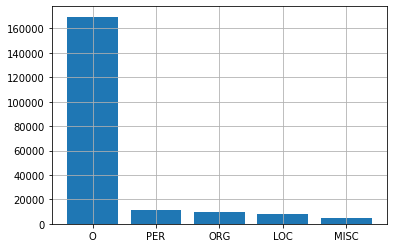

Valid distribution


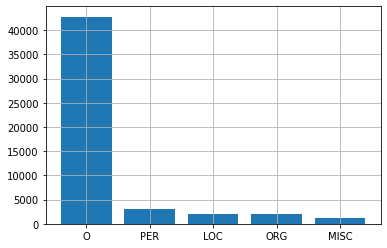

In [11]:
def visualize_distr(data: Counter):
  values = [y for y in sorted(data.values(), reverse=True)]
  labels = list(itertools.chain.from_iterable([[x for (x, y) in data.items() if y==value] for value in values]))
  plt.bar(x=labels, height=values)
  plt.grid(True)
  plt.show()


print("Train distribution")
visualize_distr(train_distribution)
print("Valid distribution")
visualize_distr(valid_distribution)

In [12]:
class NERDataset(Dataset):

  def __init__(self, data):
    self.sentence = data['sentences']
    self.labels = data['labels_per_sent']

  def __getitem__(self, index):
    return {'sentence': self.sentence[index], 
            'labels': self.labels[index]}

  def __len__(self):
    return len(self.labels)

train_dataset = NERDataset(train)
valid_dataset = NERDataset(valid)

In [13]:
tag2idx = {'PAD': 0, 'LOC': 1, 'MISC': 2, 'O': 3, 'ORG': 4, 'PER': 5}

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [15]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        tokenized_sentence.extend(tokenized_word)

        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


def labels_to_idx(labels):
    return list(itertools.chain.from_iterable([[0], [tag2idx[i] for i in labels], [0]]))


def get_padded(values):
    max_len = 0
    for value in values:
        if len(value) > max_len:
            max_len = len(value)

    padded = np.array([value + [0]*(max_len-len(value)) for value in values])

    return padded


def collate_fn(batch):

    inp = []
    labels = []
    for elem in batch:
        tokenized_inputs, lbls = tokenize_and_preserve_labels(elem['sentence'], elem['labels'])
        inp.append(tokenizer.encode_plus(tokenized_inputs, 
                                         None, 
                                         add_special_tokens=True, 
                                         return_token_type_ids=False)['input_ids'])
        labels.append(labels_to_idx(lbls))

    inputs = get_padded(inp) 
    labels = get_padded(labels)
    attention_mask = get_padded([[1 for i in elem] for elem in inp]) 

    return {"inputs": torch.tensor(inputs), "labels": torch.LongTensor(labels), 'attention_mask': torch.tensor(attention_mask)}

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [17]:
from transformers import BertForTokenClassification, AdamW

pretrained_model = BertForTokenClassification.from_pretrained( "bert-base-cased",
                                                               num_labels=len(tag2idx),
                                                               output_attentions = False,
                                                               output_hidden_states = False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [18]:
class NERModel(nn.Module):

  def __init__(self, pretrained_model):
    super().__init__()
    
    self.bert = pretrained_model

  def forward(self, inputs, attention_mask=None, labels=None, token_type_ids=None):
    outputs = self.bert(inputs,
                        token_type_ids=token_type_ids,
                        attention_mask=attention_mask,
                        labels=labels)

    return outputs

In [19]:
device = "cuda:0"

In [20]:
model = NERModel(pretrained_model)
model = model.to(device)

In [21]:
param_optimizer = list(model.bert.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
                                 'weight_decay_rate': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
                                 'weight_decay_rate': 0.0}]

optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5, eps=1e-8)

In [22]:
def transform_logits(predictions: torch.tensor):
  predictions = predictions.tolist()
  logits2idx = []
  logits2idx.extend([list(p) for p in np.argmax(predictions, axis=2)])
  transformed_logits = []
  for elem in logits2idx:
    transformed_logits.append(list(itertools.chain.from_iterable([[key for (key, value) in tag2idx.items() if value==i] for i in elem]))[1:])
  return transformed_logits

def transform_target(target_labels: torch.tensor):
  target_labels = target_labels.tolist()
  transformed_target = []
  for elem in target_labels:
    transformed_target.append(list(itertools.chain.from_iterable([[key for (key, value) in tag2idx.items() if value==i] for i in elem]))[1:])
  return transformed_target

In [23]:
def count_metrics(gold_labels_per_sentence: List[List[str]], predict_labels_per_sentence: List[List[str]]):
  gold_labels = [l for l_per_sent in gold_labels_per_sentence for l in l_per_sent]
  predict_labels = [l for l_per_sent in predict_labels_per_sentence for l in l_per_sent]
  print(classification_report(gold_labels, predict_labels))

In [24]:
def predict_preprocessing(gold_labels: List[str], predicted_labels: List[str]):
  processed_predict = []
  for i in range(len(gold_labels)):
    sent_len = len(gold_labels[i])
    processed_predict.append(predicted_labels[i][:sent_len])
  return processed_predict

In [25]:
losses = {"train_losses": [], "valid_losses": []}

epochs = 3
CLIP = 1.0

for epoch in range(epochs):

  print(f"Start eposh #{epoch}")
  
  train_loss_sum = 0
  model.train()
  for i, train_batch in enumerate(train_dataloader):
    torch.cuda.empty_cache()
    inp = train_batch['inputs'].to(device)
    lbls = train_batch['labels'].to(device)
    attn = train_batch['attention_mask'].to(device)

    optimizer.zero_grad()

    outputs = model.forward(inp, attention_mask=attn, labels=lbls)

    loss = outputs.loss
    loss.backward()
    torch.nn.utils.clip_grad_norm_(parameters=model.bert.parameters(), max_norm=CLIP)
    optimizer.step()

    train_loss_sum += loss.cpu().detach().numpy().item()

  losses["train_losses"].append(train_loss_sum/(i+1))

  predict_labels, gold_labels = [], []

  val_loss_sum = 0
  model.eval()
  with torch.no_grad():
    for i, valid_batch in enumerate(valid_dataloader):
      torch.cuda.empty_cache()
      inp = valid_batch['inputs'].to(device)
      lbls = valid_batch['labels'].to(device)
      attn = valid_batch['attention_mask'].to(device)

      outputs = model.forward(inp, attention_mask=attn, labels=lbls)
      loss = outputs.loss
      logits = outputs.logits

      val_loss_sum += loss.cpu().detach().numpy().item()
      gold_labels.append(transform_target(valid_batch["labels"]))
      predict_labels.append(transform_logits(logits.cpu()))

  losses["valid_losses"].append(val_loss_sum/(i+1))

  gold_labels = list(itertools.chain.from_iterable(gold_labels))
  gold_labels = [[x for x in elem if x !='PAD'] for elem in gold_labels]
  predict_labels = list(itertools.chain.from_iterable(predict_labels))
  predict_labels = predict_preprocessing(gold_labels, predict_labels)
  
  count_metrics(gold_labels, predict_labels)
  
  print(f"End eposh #{epoch}")

Start eposh #0
              precision    recall  f1-score   support

         LOC       0.97      0.93      0.95      4016
        MISC       0.89      0.85      0.87      2071
           O       0.99      1.00      0.99     51723
         ORG       0.94      0.92      0.93      3781
         PER       0.98      0.98      0.98      6357

    accuracy                           0.98     67948
   macro avg       0.95      0.93      0.94     67948
weighted avg       0.98      0.98      0.98     67948

End eposh #0
Start eposh #1
              precision    recall  f1-score   support

         LOC       0.96      0.96      0.96      4016
        MISC       0.91      0.89      0.90      2071
           O       0.99      1.00      1.00     51723
         ORG       0.95      0.93      0.94      3781
         PER       0.98      0.98      0.98      6357

    accuracy                           0.99     67948
   macro avg       0.96      0.95      0.96     67948
weighted avg       0.99      0.99 

In [26]:
print('Model f1_score: {0:.6f}'.format(f1_score(gold_labels, predict_labels)))
print('Model accuracy: {0:.6f}'.format(accuracy_score(gold_labels, predict_labels)))

Model f1_score: 0.944546
Model accuracy: 0.985754


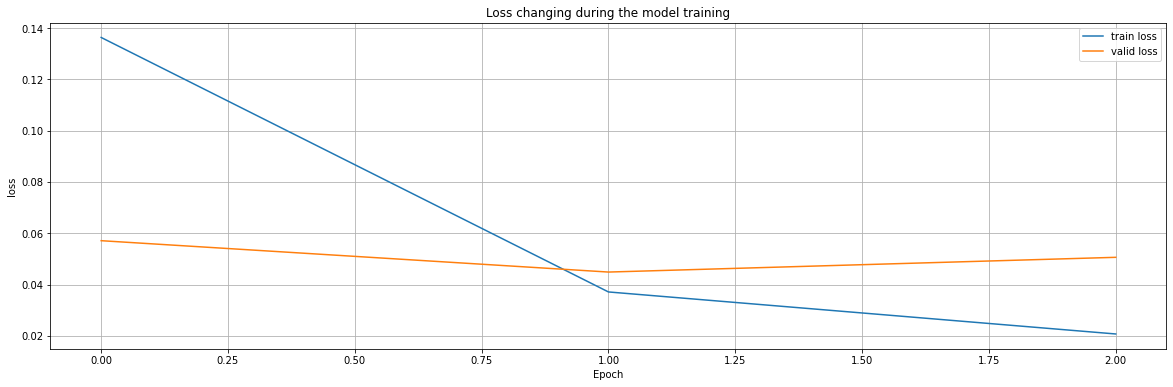

In [27]:
plt.rcParams["figure.figsize"] = (20,6)
plt.plot(losses["train_losses"], label='train loss')
plt.plot(losses["valid_losses"], label='valid loss')
plt.grid(True)
plt.title('Loss changing during the model training')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show();

In [28]:
def show_example(sentence, tokenizer, model):
  tokenized_sentence = tokenizer.encode(sentence)
  input_ids = torch.tensor([tokenized_sentence]).cuda()

  model.eval()
  with torch.no_grad():
    output = model(input_ids)

  label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

  tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])

  new_tokens, new_labels = [], []
  for token, label_idx in zip(tokens, label_indices[0]):
      if token.startswith("##"):
          new_tokens[-1] = new_tokens[-1] + token[2:]
      else:
          new_labels.append([key for (key, value) in tag2idx.items() if value==label_idx])
          new_tokens.append(token)

  new_labels = list(itertools.chain.from_iterable(new_labels))
  for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

In [29]:
test_sentence = """
In a flier distributed on Capitol Hill last week, Elon Musk’s SpaceX warned that 
legislation now being considered would reward “Jeff Bezos with a $10 billion 
sole-source hand-out” that would tie up NASA’s moon plans and hand “space leadership to China.” 
"""

show_example(test_sentence, tokenizer, model)

PAD	[CLS]
O	In
O	a
O	flier
O	distributed
O	on
LOC	Capitol
LOC	Hill
O	last
O	week
O	,
PER	Elon
PER	Musk
O	’
O	s
ORG	SpaceX
O	warned
O	that
O	legislation
O	now
O	being
O	considered
O	would
O	reward
O	“
PER	Jeff
PER	Bezos
O	with
O	a
O	$
O	10
O	billion
O	sole
O	-
O	source
O	hand
O	-
O	out
O	”
O	that
O	would
O	tie
O	up
ORG	NASA
O	’
O	s
O	moon
O	plans
O	and
O	hand
O	“
O	space
O	leadership
O	to
LOC	China
O	.
O	”
PAD	[SEP]


The solution is based on this [approach](https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/)  and on the NLP's homeworks of the DLS MIPT